In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
import pandas as pd
import sys
sys.path.append('../')
import velocity_tools.velocity_tools.stream_lines as SL
from scipy import ndimage
# astropy
# from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
# import aplpy
from regions import Regions
from pvextractor import PathFromCenter

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import Rectangle
# import matplotlib.ticker as mticker
# from matplotlib.patches import Circle, Ellipse
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
# from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import AsinhNorm
import seaborn as sns
from scipy.stats import gaussian_kde

from copy import copy

%matplotlib inline

In [2]:
hc3nfile = 'data/NGC1333_HC3N_L24-merged_small_K.fits'
hc3nmom0file = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
hc3nmom0_cloudrangefile = 'data/NGC1333_HC3N_L24-merged_small_K_5.0_10.0_mom0.fits'
hc3nrmsfile = 'data/NGC1333_HC3N_L24-merged_small_K_rms.fits'
hc3nsnrfile = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_snr.fits'
sourcecat = 'data/my_catalog_vel.csv'
xraycat = 'data/xray_sources_NGC1333_phot_SE.csv'

n2hpfile = 'data/NGC1333-N2Hp_match_kms_F1F_01_12.fits'
n2hpmom0file = 'data/NGC1333-N2Hp_match_kms_F1F_01_12_K_5_10_mom0.fits'
n2hpparamsfile = 'first_look/fit_N2Hp/NGC1333-N2Hp_match_fit_near_thick.fits'

n2hpmlex1file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x1_filtered_QA.fits'
n2hpmlex2file = 'bayes_frame/nested-sampling/N2Hp/NGC1333-SE-mle-x2_filtered_QA.fits'

hc3nmlex1file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_selected.fits'
hc3nmlex2file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x2_selected.fits'
hc3nmlex3file = 'bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x3_selected.fits'

ncompfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC.fits'
ncompflagfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC_flag.fits'

ncompfilebayes = 'bayes_frame/nested-sampling/HC3N/npeaks_cut5.fits'

n2hpncompfilebayes = 'bayes_frame/nested-sampling/N2Hp/npeaks_cut5_noislands_QA.fits'

distance = 298 # pc
scalebarsize = 10000 #au
scalebarsize_arcsec = scalebarsize / distance * u.arcsec

In [3]:
hc3nmom0, header2dhc3n = fits.getdata(hc3nmom0file, header=True)
mom0hc3n_cloud = fits.getdata(hc3nmom0_cloudrangefile)
wcs = WCS(header2dhc3n)
hc3nsnr = fits.getdata(hc3nsnrfile)

bmaj, bmin, bpa = np.array([header2dhc3n['bmaj'], header2dhc3n['bmin'], header2dhc3n['bpa']]) * u.deg
cubehc3n = SpectralCube.read(hc3nfile)
catalog_protostars = pd.read_csv(sourcecat)
# catalog_protostars_extended = pd.read_csv(sourcecat_extended)
catalog_xray = pd.read_csv(xraycat)
ncomp = fits.getdata(ncompfile)
ncompflag = fits.getdata(ncompflagfile)

ncompbayes = fits.getdata(ncompfilebayes)
n2hpncompbayes = fits.getdata(n2hpncompfilebayes)

mom0n2hp, header2dn2hp = fits.getdata(n2hpmom0file, header=True)
mom0n2hp = mom0n2hp # / 1000 # to K km s-1
wcsn2hp = WCS(header2dn2hp)
bmajn2hp, bminn2hp, bpan2hp = np.array([header2dn2hp['bmaj'], header2dn2hp['bmin'], header2dn2hp['bpa']]) * u.deg
cuben2hp = SpectralCube.read(n2hpfile)

n2hpmlex1 = fits.getdata(n2hpmlex1file)
n2hpmlex2 = fits.getdata(n2hpmlex2file)

hc3nmlex1 = fits.getdata(hc3nmlex1file)
hc3nmlex2 = fits.getdata(hc3nmlex2file)
hc3nmlex3 = fits.getdata(hc3nmlex3file)

In [4]:
catalog_protostars

,Source,RAJ2000,DEJ2000,Other,Mult,Class,Lbol,e_Lbol,Tbol,e_Tbol,SimbadName,vlsr,e_vlsr,ref_vlsr
0,Per-emb-3,52.252396,31.200057,---,N,0,0.50,0.06,32.0,2.0,[EES2009] Per-emb 3,7.30,0.01000,Stephens+19
1,IRAS4A,52.293904,31.225259,NGC 1333 IRAS4A,Y,0,7.00,0.70,29.0,2.0,[EES2009] Per-emb 12,6.90,0.00500,Stephens+19
2,IRAS4B,52.300067,31.218898,NGC 1333 IRAS4B,Y,0,4.00,0.30,28.0,1.0,[EES2009] Per-emb 13,7.10,0.00900,Stephens+19
3,Per-emb-14,52.306450,31.232819,NGC 1333 IRAS4C,N,0,0.70,0.08,31.0,2.0,[EES2009] Per-emb 14,7.90,0.03000,Stephens+19
4,Per-emb-15,52.266896,31.246177,"RNO15-FIR, SK 14",N,0,0.40,0.10,36.0,4.0,[EES2009] Per-emb 15,6.80,0.01000,Stephens+19
5,Per-emb-27,52.231538,31.243618,NGC 1333 IRAS2A,Y,0/I,19.00,0.40,69.0,1.0,[EES2009] Per-emb 27,8.10,0.02000,Stephens+19
6,Per-emb-36,52.239058,31.237714,NGC 1333 IRAS2B,Y,I,5.30,1.00,106.0,12.0,[EES2009] Per-emb 36,6.90,0.02000,Stephens+19
7,Per-emb-44,52.265683,31.267724,SVS13A,Y,0/I,32.50,7.10,188.0,9.0,[EES2009] Per-emb 44,8.70,0.02000,Stephens+19
8,Per-bolo-45,52.282083,31.288000,Per-Bolo-45,N,0,0.05,0.05,15.0,NaN,[EYG2006] Bolo 45,NaN,NaN,NaN
9,SVS13C,52.258208,31.260570,SVS13C,Y,0,1.50,0.20,21.0,1.0,[SVS76] NGC 1333 13C,8.90,0.02000,Stephens+19


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_mylist.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# this is the same moment but between 5 and 10, where the cloud emission is
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(mom0hc3n_cloud, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_cloud_mylist.pdf', bbox_inches='tight', dpi=100)

In [ ]:
outflowsources = ['Per3', 'Per12', 'Per13', 'Per15', 'Per27', 'Per36', 'Per44SVS13B', 'SVS13C']
outflowfolder = 'data/MASSES/'
outflowbluebase = '{0}.12CO21.robust1_blue'
outflowredbase = '{0}.12CO21.robust1_red'
# contourbluelist = np.array([[0.25, 0.2], [3, 12], [3, 6], [1.6, 1], [2.2, 4], [2.4, 2.4], [3.3, 10], [2, 4]]) # start, step
contourbluelist = np.array([[0.25, 0.6], [3, 24], [3, 18], [1.6, 3], [2.2, 12], [2.4, 4.8], [3.3, 20], [2, 12]]) # start, step
# contourredlist = np.array([[0.7,1.5], [3.5,10], [1.6, 5], [0.6,0.7], [1.5, 3], [5, 5], [6, 10], [3, 3]])
contourredlist = np.array([[0.7,4.5], [3.5,30], [1.6, 15], [0.6,2.1], [1.5, 9], [5, 15], [6, 30], [3, 9]])

# extra sources
outflowIRAS4Cdata, outflowIRAS4Chead = fits.getdata('data/ALMA/IRAS4C_ALMA_CS_5_4_vel_6_9.5.fits', header=True)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('gist_gray').copy()
cmap.set_bad('0.85')
# norm = AsinhNorm(linear_width=0.1, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap, vmin=0, vmax=3) #,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# ax.contour(outflowIRAS4Cdata, transform=ax.get_transform(WCS(outflowIRAS4Chead)), levels=0.0074*np.array([3, 6, 9]), colors='cyan', linewidths=0.3)
#IRAS 4C
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)

#-1.5708
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows_wsourcesextended_gray.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# this is the same plot but for the cloud range
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('gist_gray').copy()
cmap.set_bad('0.85')
# norm = AsinhNorm(linear_width=0.1, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap, vmin=0, vmax=3) #,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# ax.contour(outflowIRAS4Cdata, transform=ax.get_transform(WCS(outflowIRAS4Chead)), levels=0.0074*np.array([3, 6, 9]), colors='cyan', linewidths=0.3)
#IRAS 4C
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)

#-1.5708
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_cloud_woutflows_wsourcesextended_gray.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.2, vmin=0)

im = ax.imshow(hc3nmom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.5)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.5)

add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_mom0_woutflows.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=2, vmin=0)

im = ax.imshow(mom0n2hp, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/N2Hp_mom0.pdf', bbox_inches='tight', dpi=100)

## Channel maps of the molecules

In [ ]:
cubehc3n = SpectralCube.read(hc3nfile).with_spectral_unit(u.km/u.s)
wcsskyhc3n = WCS(cubehc3n.header).celestial
cuben2hp = SpectralCube.read(n2hpfile).with_spectral_unit(u.km/u.s)
wcsskyn2hp = WCS(cuben2hp.header).celestial

In [ ]:

velinit = 5.61753 *u.km/u.s
deltav = 0.20 *u.km/u.s
figname = 'figures/N2Hp_channel_map_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 5
velarray = cuben2hp.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=2, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10,8), subplot_kw={'projection': wcsskyn2hp})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cuben2hp.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, vmin=vmin, vmax=vmax) #, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.2), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nNC$_2$H$^+$ ($1_{01}-0_{12}$)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.35])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

In [ ]:
# we do the channel map for the main filament body, the spectra should show the outflow emission
velinit = 5.69638 *u.km/u.s
deltav = 0.21 *u.km/u.s
figname = 'figures/HC3N_channel_map_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 4
velarray = cubehc3n.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=0.5, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10,8), subplot_kw={'projection': wcsskyhc3n})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cubehc3n.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.2), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

In [ ]:
# we do also channel maps zooming into the shape of the monster outflow

# we do the channel map for the main filament body, the spectra should show the outflow emission
velinit = 5.90232 *u.km/u.s
deltav = 0.42 *u.km/u.s
figname = 'figures/HC3N_channel_map_zoom_outflow_{0}_{1}.pdf'.format(velinit.value, deltav.value)
nrows = 4
ncols = 5
vmin = 0
vmax = 4
xmin, xmax = 388-80, 388+80
ymin, ymax = 301-80, 301+80
velarray = cubehc3n.spectral_axis.value
velsample = np.arange(velinit.value, (velinit+deltav*nrows*ncols).value, deltav.value)
scalebarsize = 10000
scalebardeg = (scalebarsize / distance) / 3600 * u.deg

fontprops = fm.FontProperties(size=7)
norm = AsinhNorm(linear_width=0.5, vmin=vmin, vmax=vmax)
fig, axlist = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12,8), subplot_kw={'projection': wcsskyhc3n})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velarray-velsample[i]))
    planevel = cubehc3n.unmasked_data[indexvel, :, :].value
    im = ax.imshow(planevel, norm=norm)
    ax.annotate(str(np.round(velsample[i], 2))+r' km s$^{-1}$', (0.89, 0.1), xycoords='axes fraction', color='k', size=6, rotation=90)
    
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    # ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('NOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.5, 0.1), xycoords='axes fraction', color='k', size=5)

    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.05, ec = 'k', fc='k')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (J2000)', size=6)
        lat.set_axislabel('Declination (J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{\mathrm{MB}}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
fig.subplots_adjust(hspace = 0, wspace=-0.5) 

fig.savefig(figname, bbox_inches='tight', dpi=100)

## Fit results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
ncomp[np.where(np.isnan(ncomp))] = 0
ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncomp,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompAIC_wflag.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# 1 component fit using the N2Hp hyperfine component fitting
paramscuben2hp = fits.getdata(n2hpparamsfile)

fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

im = ax.imshow(paramscuben2hp[2], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, label=r'Velocity (km s$^{-1}$)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
fig.savefig('figures/N2Hp_vlsr_thick.pdf', bbox_inches='tight', dpi=100)

## Nested sampling fit results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompbayes.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# Like the previous oe but with SNR levels
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
CS = ax.contour(hc3nsnr, colors='k', levels=[5, 10], linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
fig.savefig('figures/HC3N_ncompbayes_wsnr.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# like the previous but with outflows
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in range(len(outflowsources)):
    blueimage, bluehead = fits.getdata(outflowfolder+outflowbluebase.format(outflowsources[i])+'.fits', header=True)
    bluerange = np.arange(contourbluelist[i, 0], contourbluelist[i, 0]*100, contourbluelist[i, 1])
    ax.contour(blueimage, transform=ax.get_transform(WCS(bluehead)), levels=bluerange, colors='blue', linewidths=0.3)
    redimage, redhead = fits.getdata(outflowfolder+outflowredbase.format(outflowsources[i])+'.fits', header=True)
    redrange = np.arange(contourredlist[i, 0], contourredlist[i, 0]*100, contourredlist[i, 1])
    ax.contour(redimage, transform=ax.get_transform(WCS(redhead)), levels=redrange, colors='red', linewidths=0.3)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))

#IRAS 4C
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
ax.arrow(catalog_protostars.loc[3, 'RAJ2000'], catalog_protostars.loc[3, 'DEJ2000'],  -0.006, 0, transform=ax.get_transform('world'), fc='w', width=0.0008)
# IRAS 4B2
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  0.006*np.sin(1.32645), 0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0008)
ax.arrow(catalog_protostars.loc[11, 'RAJ2000'], catalog_protostars.loc[11, 'DEJ2000'],  -0.006*np.sin(1.32645), -0.006*np.cos(1.32645), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0008)


fig.savefig('figures/HC3N_ncompbayes_woutfows.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')

im = ax.imshow(hc3nmlex1[0], cmap=cmap)
fig.colorbar(im, ax=ax, label=r'Tpeak (K)')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='r', edgecolor='None', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='r', edgecolor='None', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='r', edgecolor='None', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
# for i in catalog_xray.index.values:
#     ax.scatter(catalog_xray.loc[i, 'RAJ2000'], catalog_xray.loc[i, 'DEJ2000'], 
#                transform=ax.get_transform('world'), marker='x', facecolor='r', s=70)
fig.savefig('figures/HC3N_amplitude_mlex1_extendedlist.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

hc3nmlexlist = [hc3nmlex1[1], hc3nmlex2[1], hc3nmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(hc3nmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i==3:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    else:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label='Velocity',  shrink=0.8)

    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for i in catalog_protostars.index.values:
        ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=50)

fig.savefig('figures/HC3N_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
n2hpncompbayes[np.where(np.isnan(n2hpncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(n2hpncompbayes,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor(cmap(0))
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/N2Hp_ncompbayes.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = 6
vmax= 9

n2hpmlexlist = [n2hpmlex1[1], n2hpmlex2[1], n2hpmlex2[4]]

for i, ax in enumerate(axes):
    
    sc1 = ax.imshow(n2hpmlexlist[i], cmap=cmap, vmin=vmin, vmax=vmax)
    

    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
        
    if i==2:
        fig.colorbar(sc1, ax=axes, label=r'Velocity (km s$^{-1}$)',  shrink=0.8)

    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    ax.set_facecolor('0.85')
    for i in catalog_protostars.index.values:
        if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
        elif catalog_protostars.loc[i, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
        else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4, fontsize=8)

fig.savefig('figures/N2Hp_ncompbayes_vel.pdf', bbox_inches='tight', dpi=100)

### Spectra examples

In [ ]:
positionsx = [52.3095580, 52.3015442, 52.2992761, 52.2929745, 52.2940795, 52.2818201, 52.2874857, 52.2766957, 52.2545864, 52.2502420]
positionsy = [31.2140899, 31.2146415, 31.2196714, 31.2225458, 31.2262269, 31.2399025, 31.2460018, 31.2393496, 31.2388003, 31.2570277]
labels_spectra = np.linspace(1, len(positionsx), len(positionsx))
mlex_all = [hc3nmlex1, hc3nmlex2, hc3nmlex3]

velocityarray = cubehc3n.spectral_axis

from astropy.modeling.functional_models import Gaussian1D

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 4).copy()
ncompbayes[np.where(np.isnan(ncompbayes))] = 0
# ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncompbayes,  cmap=cmap, vmin=-0.5, vmax=3.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

for ra, dec, label in zip(positionsx, positionsy, labels_spectra):
    ax.scatter(ra, dec, transform=ax.get_transform('world'), marker='d', facecolor='None', edgecolor='w', s=50, zorder=100)
    ax.text(ra-0.002, dec-0.002, str(label), transform=ax.get_transform('world'), fontsize=8, color='k')
ax.set_facecolor(cmap(0))
# fig.savefig('figures/HC3N_ncompbayes_wsnr.pdf', bbox_inches='tight', dpi=100)

In [ ]:
for ra, dec, label in zip(positionsx, positionsy, labels_spectra):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([ra], [dec], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(str(label), (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    
                      
    

In [ ]:
# we can also plot the spectra in the locations of the protostars
for i in catalog_protostars.index.values:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([catalog_protostars.loc[i, 'RAJ2000']], [catalog_protostars.loc[i, 'DEJ2000']], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    shape = np.shape(cubehc3n[0])
    if pixx > shape[1] or pixy > shape[0]: continue
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(catalog_protostars.loc[i, 'Source'], (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    
                      
    

In [ ]:
# there are two peaks that are only one gaussian that call my attention
# one of them coincides with an N2Hp peak, but the other one does not.
positionsx_peaks = [52.2503987, 52.2735308]
positionsy_peaks = [31.2515837, 31.2691702]
labels = ['Peak 1', 'Peak2']
for ra, dec, label in zip(positionsx_peaks, positionsy_peaks, labels):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    pixx, pixy = wcs.all_world2pix([ra], [dec], 0)
    pixx, pixy = int(pixx[0]), int(pixy[0])
    
    intensity = cubehc3n[:, pixy, pixx]
    ax.plot(velocityarray, intensity, drawstyle='steps-mid', color='k', linewidth=0.5)
    ax.set_xlabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)')
    ax.set_ylabel(r'$T_{\mathrm{MB}}$ (K)')
    ax.annotate(str(label), (0.1, 0.9), xycoords='axes fraction')
    ax.set_xlim([-5, 20])
    n = int(ncompbayes[pixy, pixx] - 1)
    if n == -1: print('Position {0}, {1} has no fit'.format(ra, dec))
    elif n==0:
        gaussian = Gaussian1D(amplitude=mlex_all[0][0, pixy, pixx], mean=mlex_all[0][1, pixy, pixx], stddev=mlex_all[0][2, pixy, pixx])
        ax.plot(velocityarray, gaussian(velocityarray.value))
    elif n==1:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[1][0+n*3, pixy, pixx], mean=mlex_all[1][1+n*3, pixy, pixx], stddev=mlex_all[1][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    else:
        curve_total = np.zeros(np.shape(velocityarray))
        while n != -1:
            gaussian = Gaussian1D(amplitude=mlex_all[2][0+n*3, pixy, pixx], mean=mlex_all[2][1+n*3, pixy, pixx], stddev=mlex_all[2][2+n*3, pixy, pixx])
            curve_total += gaussian(velocityarray.value)
            ax.plot(velocityarray, gaussian(velocityarray.value))
            n-=1
        ax.plot(velocityarray, curve_total, 'k--')
    



## Clustering results

In [ ]:
cluster0_N2Hp_file = 'clustering/cluster0_DBSCAN_N2Hp.fits'
cluster1_N2Hp_file = 'clustering/cluster1_DBSCAN_N2Hp.fits'
cluster2_N2Hp_file = 'clustering/cluster2_DBSCAN_N2Hp.fits'
cluster3_N2Hp_file = 'clustering/cluster3_DBSCAN_N2Hp.fits'
cluster4_N2Hp_file = 'clustering/cluster4_DBSCAN_N2Hp.fits'

cluster0_manual_HC3N_file = 'clustering/cluster0_manual_HC3N.fits'
cluster1_manual_HC3N_file = 'clustering/cluster1_manual_HC3N.fits'
cluster0_dist_HC3N_file = 'clustering/cluster1_HC3N_w0.5_r2.fits'

cluster0_HC3N_file = 'clustering/cluster0_HDBSCAN_HC3N.fits'
cluster1_HC3N_file = 'clustering/cluster1_HDBSCAN_HC3N.fits'
cluster2_HC3N_file = 'clustering/cluster2_HDBSCAN_HC3N.fits'
cluster3_HC3N_file = 'clustering/cluster3_HDBSCAN_HC3N.fits'
cluster4_HC3N_file = 'clustering/cluster4_HDBSCAN_HC3N.fits'
cluster5_HC3N_file = 'clustering/cluster5_HDBSCAN_HC3N.fits'
cluster6_HC3N_file = 'clustering/cluster6_HDBSCAN_HC3N.fits'
cluster7_HC3N_file = 'clustering/cluster7_HDBSCAN_HC3N.fits'

diff_cluster0_dist_HC3N_N2Hp_min_file = 'clustering/diff_HC3N_w_N2Hp_minimum' #this can be also kde 
diff_cluster0_manual_HC3N_cluster0_dbscan_N2Hp_file = 'clustering/diff_HC3N_0_w_N2Hp_clump0' #this can be also kde 
diff_cluster1_manual_HC3N_cluster1_dbscan_N2Hp_file = 'clustering/diff_HC3N_1_w_N2Hp_clump1' #this can be also kde 

In [ ]:
cluster0_N2Hp, header_clusterN2Hp = fits.getdata(cluster0_N2Hp_file, header=True)
cluster1_N2Hp = fits.getdata(cluster1_N2Hp_file)
cluster2_N2Hp = fits.getdata(cluster2_N2Hp_file)
cluster3_N2Hp = fits.getdata(cluster3_N2Hp_file)
cluster4_N2Hp = fits.getdata(cluster4_N2Hp_file)

cluster0_dist_HC3N = fits.getdata(cluster0_dist_HC3N_file)
cluster0_manual_HC3N = fits.getdata(cluster0_manual_HC3N_file)
cluster1_manual_HC3N = fits.getdata(cluster1_manual_HC3N_file)

cluster0_HC3N, header_clusterHC3N = fits.getdata(cluster0_HC3N_file, header=True)
cluster1_HC3N = fits.getdata(cluster1_HC3N_file)
cluster2_HC3N = fits.getdata(cluster2_HC3N_file)
cluster3_HC3N = fits.getdata(cluster3_HC3N_file)
cluster4_HC3N = fits.getdata(cluster4_HC3N_file)
cluster5_HC3N = fits.getdata(cluster5_HC3N_file)
cluster6_HC3N = fits.getdata(cluster6_HC3N_file)
cluster7_HC3N = fits.getdata(cluster7_HC3N_file)


wcs_N2Hp = WCS(header_clusterN2Hp).celestial
wcs_HC3N = WCS(header_clusterHC3N).celestial

In [ ]:
# we check the positions of all the clusters
n2hpclusterlist = [cluster0_N2Hp, cluster1_N2Hp, cluster2_N2Hp, cluster3_N2Hp, cluster4_N2Hp]
mask_n2hp_cluster = np.zeros((5, header_clusterN2Hp['NAXIS2'], header_clusterN2Hp['NAXIS1']))

palette = sns.color_palette()
colors = [palette[col] for col in range(len(n2hpclusterlist))]
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})

for i, cluster in enumerate(n2hpclusterlist):
    mask_n2hp_cluster[i, :, :] = np.where(~np.isnan(cluster[0]), 1, 0)
    color = colors[i]
    cs = ax.contour(mask_n2hp_cluster[i], colors=[color], levels=[0.5], linewidths=2, alpha=0.7)

proxy = [plt.Rectangle((0,0),1,1,fc = colors[i]) for i in range(len(n2hpclusterlist))]
legends = ['Cluster {}'.format(i) for i in range(len(n2hpclusterlist))]
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
ax.legend(proxy, legends, loc=4)

fig.savefig('figures/N2Hp_clusters_DBSCAN.pdf', bbox_inches='tight', dpi=100)

In [ ]:
hc3nclusterlist = [cluster0_HC3N, cluster1_HC3N, cluster2_HC3N, cluster3_HC3N, cluster4_HC3N, cluster5_HC3N, cluster6_HC3N, cluster7_HC3N]
mask_hc3n_cluster = np.zeros((len(hc3nclusterlist), header_clusterHC3N['NAXIS2'], header_clusterHC3N['NAXIS1']))

palette = sns.color_palette()
colors = [palette[col] for col in range(len(hc3nclusterlist))]
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})

for i, cluster in enumerate(hc3nclusterlist):
    mask_hc3n_cluster[i, :, :] = np.where(~np.isnan(cluster[0]), 1, 0)
    color = colors[i]
    ax.contour(mask_hc3n_cluster[i], colors=[color], levels=[0.5], linewidths=2, alpha=0.7)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
proxy = [plt.Rectangle((0,0),1,1,fc = colors[i]) for i in range(len(hc3nclusterlist))]
legends = ['Cluster {}'.format(i) for i in range(len(hc3nclusterlist))]
ax.legend(proxy, legends, loc=4)
fig.savefig('figures/HC3N_clusters_HDBSCAN.pdf', bbox_inches='tight', dpi=100)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs_N2Hp})

vminlist = [0,6.3,0]
vmaxlist = [5,8.8,1.2]
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']
cmaplist = ['viridis', 'RdYlBu_r','inferno']
for i, ax in enumerate(axes):
    cmap = cm.get_cmap(cmaplist[i]).copy()
    cmap.set_bad('0.85')
    sc1 = ax.imshow(cluster0_N2Hp[i], cmap=cmap, vmin=vminlist[i], vmax=vmaxlist[i])
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
    fig.colorbar(sc1, ax=ax, label=labels[i], shrink=0.5)
    add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
    ax.set_facecolor('0.85')
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for j in catalog_protostars.index.values:
        if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
        else: continue
    if i == 2 : ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)
fig.savefig('figures/N2Hp_cluster0_DBSCAN.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# We now know which clusters we can plot together in velocity:
# Clusters 0, and 3 for N2Hp

clusters_red_list_N2Hp = [cluster0_N2Hp, cluster3_N2Hp]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
for k, cluster in enumerate(clusters_red_list_N2Hp):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/N2Hp_cluster0_3_props.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# We now know which clusters we can plot together in velocity:
# Clusters 1, 2 and 4 for N2Hp

clusters_blue_list_N2Hp = [cluster1_N2Hp, cluster2_N2Hp, cluster4_N2Hp]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcsn2hp})
for k, cluster in enumerate(clusters_blue_list_N2Hp):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/N2Hp_cluster1_2_4_props.pdf', bbox_inches='tight', dpi=300)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs_HC3N})

vminlist = [0,6.3,0]
vmaxlist = [6,8.8,1.2]
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']
cmaplist = ['viridis', 'RdYlBu_r','inferno']
for i, ax in enumerate(axes):
    cmap = cm.get_cmap(cmaplist[i]).copy()
    cmap.set_bad('0.85')
    sc1 = ax.imshow(cluster0_dist_HC3N[i], cmap=cmap, vmin=vminlist[i], vmax=vmaxlist[i])
    lon = ax.coords[0]
    lat = ax.coords[1]
    # ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)
    if i:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    else:
        lon.set_axislabel('Right ascension (J2000)')
        lat.set_axislabel('Declination (J2000)')
    fig.colorbar(sc1, ax=ax, label=labels[i], shrink=0.5)
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
    ax.set_facecolor('0.85')
    add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

    for j in catalog_protostars.index.values:
        if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
            class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
            classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
        elif catalog_protostars.loc[j, 'Class'] == 'Flat':
            classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                       transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
        else: continue
    if i == 2 : ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)
fig.savefig('figures/HC3N_cluster0_distance.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# We now know which clusters we can plot together in velocity:
# Clusters 0, 1, 3 and 4

clusters_red_list_HC3N = [cluster0_HC3N, cluster1_HC3N, cluster3_HC3N, cluster4_HC3N]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
for k, cluster in enumerate(clusters_red_list_HC3N):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/HC3N_cluster0_1_3_4_props.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# We now know which clusters we can plot together in velocity:
# Clusters 5, 6 and 7

clusters_blue_list_HC3N = [cluster5_HC3N, cluster6_HC3N, cluster7_HC3N]

rangemin = [0, 5, 0]
rangemax = [6, 9, 1]

cmaplist = ['viridis', 'RdYlBu_r','inferno']
labels = [r'$T_{\mathrm{MB}}$ (K)', r'$v_{\mathrm{LSR}}$(km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']

fig, axes = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'projection': wcs})
for k, cluster in enumerate(clusters_blue_list_HC3N):
    for i in range(3):
        cmap = cm.get_cmap(cmaplist[i]).copy()
        if not k: cmap.set_bad('0.85')
        else: cmap.set_bad('0.85', alpha=0)
        sc1 = axes[i].imshow(cluster[i], cmap = cmap, vmin=rangemin[i], vmax=rangemax[i])
        lon = axes[i].coords[0]
        lat = axes[i].coords[1]
        if i:
            lon.set_ticklabel_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
        else:
            lon.set_axislabel('Right ascension (J2000)')
            lat.set_axislabel('Declination (J2000)')
        if not k:
            fig.colorbar(sc1, ax=axes[i], label=labels[i], shrink=0.56, pad=0.01)
            
            for j in catalog_protostars.index.values:
                if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
                    class0dot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=20, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
                    classIIdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=10, zorder=100)
                elif catalog_protostars.loc[j, 'Class'] == 'Flat':
                    classflatdot = axes[i].scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                               transform=axes[i].get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=10, zorder=100)
                else: continue
            axes[i].legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=8)

        add_beam(axes[i], major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)

        add_scalebar(axes[i], scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
fig.savefig('figures/HC3N_cluster5_6_7_props.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# just in case I am interested in the uncertainties of the mle
fig, ax = plt.subplots(1, 1, figsize=(4,4), subplot_kw={'projection': wcs})

for i, cluster in enumerate(clusters_blue_list_HC3N):
    cmap = cm.get_cmap('inferno').copy()
    if not i: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)
    sc1 = ax.imshow(cluster[4], cmap =cmap, vmax=0.06)
    if not i: fig.colorbar(sc1, ax=ax)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/HC3N_clusters_blue_HDBSCAN_HC3N_vel_unc.pdf', bbox_inches='tight', dpi=100)

In [ ]:
# just in case I am interested in the uncertainties of the mle
fig, ax = plt.subplots(1, 1, figsize=(4,4), subplot_kw={'projection': wcs})

for i, cluster in enumerate(clusters_red_list_HC3N):
    cmap = cm.get_cmap('inferno').copy()
    if not i: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)
    sc1 = ax.imshow(cluster[4], cmap =cmap, vmax=0.06)
    if not i: fig.colorbar(sc1, ax=ax)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/HC3N_clusters_red_HDBSCAN_HC3N_vel_unc.pdf', bbox_inches='tight', dpi=100)

### Difference between the groups' velocities

In [ ]:
diff_blue_clumps_vel_file = 'clustering/diff_HC3N_w_N2Hp_clump_blue_vel.fits'
diff_red_clumps_vel_file = 'clustering/diff_HC3N_w_N2Hp_clump_red_vel.fits'
diff_all_vel_file = 'clustering/NGC1333-SE_HC3N-N2Hp_mindiff.fits'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
diff_all_clumps = fits.getdata(diff_all_vel_file)

sc1 = ax.imshow(diff_all_clumps,  cmap=cmap, vmin=-0.5, vmax=0.5)
cax = plt.colorbar(sc1, ax=ax, label=r'$\Delta v$ (km s$^{-1}$)')
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

fig.savefig('figures/diff_clusters_all.pdf', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
diff_blue_clumps = fits.getdata(diff_blue_clumps_vel_file)

sc1 = ax.imshow(diff_blue_clumps[0],  cmap=cmap, vmin=-0.5, vmax=0.5)
cax = plt.colorbar(sc1, ax=ax, label=r'$\Delta v$ (km s$^{-1}$)')
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

ax.set_xlim([157, 315])
ax.set_ylim([140, 330])

fig.savefig('figures/diff_clusters_blue_zoom.pdf', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
diff_red_clumps = fits.getdata(diff_red_clumps_vel_file)

sc1 = ax.imshow(diff_red_clumps[0],  cmap=cmap, vmin=-0.5, vmax=0.5)
cax = plt.colorbar(sc1, ax=ax, label=r'$\Delta v$ (km s$^{-1}$)')
# ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='r', pad=0.1)


for i in catalog_protostars.index.values:
    if catalog_protostars.loc[i, 'Class'] == 'I' or catalog_protostars.loc[i, 'Class'] == '0' or catalog_protostars.loc[i, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'II' or catalog_protostars.loc[i, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=50, zorder=100)
    elif catalog_protostars.loc[i, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
                   transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=50, zorder=100)
    else: continue
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4)
ax.set_facecolor('0.85')
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))

ax.set_xlim([44, 404])
ax.set_ylim([56, 448])

fig.savefig('figures/diff_clusters_red_zoom.pdf', bbox_inches='tight', dpi=300)

## Velocity gradient results

In [ ]:
velgradient_base_file = 'analysis/vel_grad_{0}_{1}_{2}.fits' # quantity, molecule, cluster number

velxfiles_HC3N_blue = [velgradient_base_file.format('x', 'HC3N', cn) for cn in [5,6,7]]
velyfiles_HC3N_blue = [velgradient_base_file.format('y', 'HC3N', cn) for cn in [5,6,7]]
velabsfiles_HC3N_blue = [velgradient_base_file.format('magnitude', 'HC3N', cn) for cn in [5,6,7]]

velx_HC3N_blue = [fits.getdata(filename) for filename in velxfiles_HC3N_blue]
vely_HC3N_blue = [fits.getdata(filename) for filename in velyfiles_HC3N_blue]
velabs_HC3N_blue = [fits.getdata(filename) for filename in velabsfiles_HC3N_blue]

velxfiles_HC3N_red = [velgradient_base_file.format('x', 'HC3N', cn) for cn in [0,1,3,4]]
velyfiles_HC3N_red = [velgradient_base_file.format('y', 'HC3N', cn) for cn in [0,1,3,4]]
velabsfiles_HC3N_red = [velgradient_base_file.format('magnitude', 'HC3N', cn) for cn in [0,1,3,4]]

velx_HC3N_red = [fits.getdata(filename) for filename in velxfiles_HC3N_red]
vely_HC3N_red = [fits.getdata(filename) for filename in velyfiles_HC3N_red]
velabs_HC3N_red = [fits.getdata(filename) for filename in velabsfiles_HC3N_red]

clusters_HC3N_blue_list = [cluster5_HC3N[1], cluster6_HC3N[1], cluster7_HC3N[1]]
clusters_HC3N_red_list = [cluster0_HC3N[1], cluster1_HC3N[1], cluster3_HC3N[1], cluster4_HC3N[1]] # we are only interested in the velocities


In [ ]:
# gradients vs velocity in the red components of HC3N
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_HC3N_red[0])[1], np.shape(velx_HC3N_red[0])[1])
yy = np.linspace(0, np.shape(velx_HC3N_red[0])[0], np.shape(velx_HC3N_red[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_HC3N_red_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_HC3N_red[k]
    vectory = vely_HC3N_red[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_HC3N_red_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# gradients vs velocity in the blue components of HC3N
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_HC3N_blue[0])[1], np.shape(velx_HC3N_blue[0])[1])
yy = np.linspace(0, np.shape(velx_HC3N_blue[0])[0], np.shape(velx_HC3N_blue[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_HC3N_blue_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_HC3N_blue[k]
    vectory = vely_HC3N_blue[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_HC3N_blue_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

In [ ]:
velgradient_base_N2Hp_file = 'analysis/vel_grad_{0}_{1}_{2}.fits' # quantity, molecule, cluster number

velxfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('x', 'N2Hp', cn) for cn in [1, 2, 4]]
velyfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('y', 'N2Hp', cn) for cn in [1, 2, 4]]
velabsfiles_N2Hp_blue = [velgradient_base_N2Hp_file.format('magnitude', 'N2Hp', cn) for cn in [1, 2, 4]]

velx_N2Hp_blue = [fits.getdata(filename) for filename in velxfiles_N2Hp_blue]
vely_N2Hp_blue = [fits.getdata(filename) for filename in velyfiles_N2Hp_blue]
velabs_N2Hp_blue = [fits.getdata(filename) for filename in velabsfiles_N2Hp_blue]

velxfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('x', 'N2Hp', cn) for cn in [0,3]]
velyfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('y', 'N2Hp', cn) for cn in [0,3]]
velabsfiles_N2Hp_red = [velgradient_base_N2Hp_file.format('magnitude', 'N2Hp', cn) for cn in [0,3]]

velx_N2Hp_red = [fits.getdata(filename) for filename in velxfiles_N2Hp_red]
vely_N2Hp_red = [fits.getdata(filename) for filename in velyfiles_N2Hp_red]
velabs_N2Hp_red = [fits.getdata(filename) for filename in velabsfiles_N2Hp_red]

clusters_N2Hp_blue_list = [cluster1_N2Hp[1], cluster2_N2Hp[1], cluster4_N2Hp[1]]
clusters_N2Hp_red_list = [cluster0_N2Hp[1], cluster3_N2Hp[1]] # we are only interested in the velocities

In [ ]:
# gradients vs velocity in the red components of N2Hp
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_N2Hp_red[0])[1], np.shape(velx_N2Hp_red[0])[1])
yy = np.linspace(0, np.shape(velx_N2Hp_red[0])[0], np.shape(velx_N2Hp_red[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_N2Hp_red_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_N2Hp_red[k]
    vectory = vely_N2Hp_red[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_N2Hp_red_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# gradients vs velocity in the bluecomponents of N2Hp
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcsn2hp})
vmin = 5
vmax = 9

ns = 5
xx = np.linspace(0, np.shape(velx_N2Hp_blue[0])[1], np.shape(velx_N2Hp_blue[0])[1])
yy = np.linspace(0, np.shape(velx_N2Hp_blue[0])[0], np.shape(velx_N2Hp_blue[0])[0])
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()



for k, cluster in enumerate(clusters_N2Hp_blue_list):
    cmap = cm.get_cmap('RdYlBu_r').copy()
    if not k: cmap.set_bad('0.85')
    else: cmap.set_bad('0.85', alpha=0)

    sc1 = ax.imshow(cluster, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    if not k: fig.colorbar(sc1, ax=ax, label=r'$v_{\mathrm{LSR}}$(km s$^{-1}$)') 
    vectorx = velx_N2Hp_blue[k]
    vectory = vely_N2Hp_blue[k]
    vectorx2 = vectorx[2::ns, 2::ns]
    vectory2 = vectory[2::ns, 2::ns]
    qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=1, scale_units='y', pivot='mid', width=0.002, color='k', zorder=100, headwidth=0, headlength=0, headaxislength=0)
    if not k: ax.quiverkey(qui, X=0.62, Y=1.05, U=10,label=r'10 km s$^{-1}$ pc$^{-1}$', labelpos='E', coordinates='axes', labelcolor='k')

ax.set_facecolor('0.85')
add_beam(ax, major=bmajn2hp, minor=bminn2hp, angle=bpan2hp, color='k', pad=0.1)
add_scalebar(ax, scalebarsize_arcsec, corner='top left', label='{} au'.format(scalebarsize))
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
for j in catalog_protostars.index.values:
    if catalog_protostars.loc[j, 'Class'] == 'I' or catalog_protostars.loc[j, 'Class'] == '0' or catalog_protostars.loc[j, 'Class'] == '0/I':
        class0dot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=40, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'II' or catalog_protostars.loc[j, 'Class'] == 'III':
        classIIdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='d', facecolor='k', edgecolor='w', s=30, zorder=100)
    elif catalog_protostars.loc[j, 'Class'] == 'Flat':
        classflatdot = ax.scatter(catalog_protostars.loc[j, 'RAJ2000'], catalog_protostars.loc[j, 'DEJ2000'], 
                    transform=ax.get_transform('world'), marker='o', facecolor='k', edgecolor='w', s=30, zorder=100)
    else: continue
    
ax.legend([class0dot, classIIdot, classflatdot], ['Class 0, 0/I, I', 'Class II', 'Flat'], frameon=False, loc=4,fontsize=10)
fig.savefig('figures/velocity_gradients_N2Hp_blue_clusters_quiver.pdf', bbox_inches='tight', dpi=300)

## Results from zooming into the protostars

In [52]:
def distance_au(x, y, xcent, ycent, header, distance_source=298):
    dist = np.hypot(np.abs(x-xcent), np.abs(y-ycent))
    return (dist*header['CDELT2'] * u.deg).to(u.arcsec).value * distance_source

def do_kde(velplane, header, ra_star, dec_star, region, distsource, xmin=0, xmax=5000, ymin=6, ymax=9):
    wcssky = WCS(header).celestial
    ylen, xlen = np.shape(velplane)
    centerxsmall, centerysmall = wcssky.all_world2pix([ra_star], [dec_star], 0)
    centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)
    XX, YY = np.meshgrid(np.linspace(0, xlen-1, xlen), np.linspace(0, ylen-1, ylen))
    distance_subcube = distance_au(XX, YY, centerxsmall, centerysmall, header, distance_source=distsource)
    mask = region.to_mask()
    cut_vel = mask.cutout(velplane)
    distance_subcube_cut = mask.cutout(distance_subcube)
    gd = (mask.data == 1)
    velsample = cut_vel[gd]
    distance_sample = distance_subcube_cut[gd]
    
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    gd_vlos = np.isfinite(velsample*distance_sample)
    values = np.vstack([distance_sample[gd_vlos], velsample[gd_vlos]])
    kernel = gaussian_kde(values)
    zz = np.reshape(kernel(positions).T, xx.shape)
    zz /= zz.max() 
    return xx, yy, zz


def get_streamer(mass, v_lsr, r0, theta0, phi0, omega0, v_r0, inc, PA, distance, ra_yso, dec_yso):
    refcenter = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
    refframe = refcenter.skyoffset_frame()
    r_c = SL.r_cent(mass, omega0, r0)
    (x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(mass=mass, r0=r0, theta0=theta0, phi0=phi0, omega=omega0, v_r0=v_r0, inc=inc, pa=PA, rmin=r_c)
    # we obtain the distance of each point in the sky
    d_sky_au = np.sqrt(x1**2 + z1**2)
    # Stream line into arcsec
    dra_stream = -x1.value / distance
    ddec_stream = z1.value / distance
    fil = SkyCoord(dra_stream*u.arcsec, ddec_stream*u.arcsec, frame=refframe).transform_to(FK5)
    velocity = v_lsr + vy1
    return fil, d_sky_au, velocity


In [40]:
# IRAS 4A

iras4a_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS4A_HC3N_cluster7.fits'
iras4a_n2hpclusterfile = 'analysis/protostar_cutouts/IRAS4A_N2Hp_cluster2.fits'
iras4a_regionfile = 'analysis/protostar_cutouts/candidate_region_IRAS4A.reg'

iras4a_hc3ncluster, iras4a_hc3nhead = fits.getdata(iras4a_hc3nclusterfile, header=True)
iras4a_wcsskyhc3n = WCS(iras4a_hc3nhead).celestial
iras4a_n2hpcluster, iras4a_n2hphead = fits.getdata(iras4a_n2hpclusterfile, header=True)
iras4a_region = Regions.read(iras4a_regionfile)[0]
iras4a_vlsr = catalog_protostars.loc[1, 'vlsr']

/tmp/ipykernel_27592/3796477839.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_27592/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


rc=46.99779223360992 AU


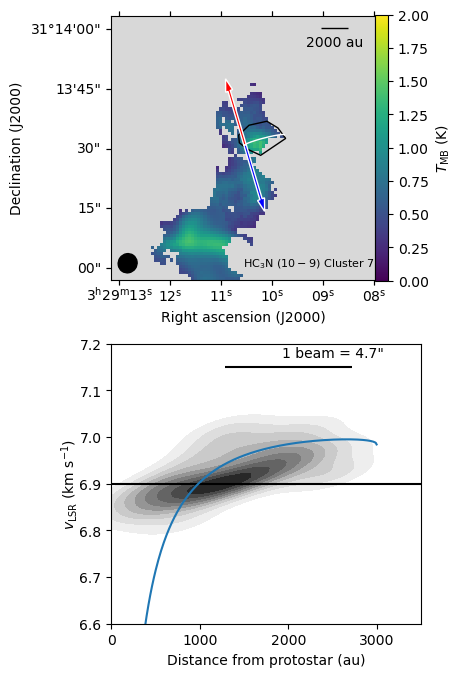

In [54]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=iras4a_wcsskyhc3n)
map = iras4a_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2

vmin = iras4a_vlsr-0.3
vmax = iras4a_vlsr+0.3
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = iras4a_region.to_pixel(iras4a_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)
# ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate(r'HC$_3$N ($10-9$) Cluster 7', (0.5, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'],  0.004*np.sin((19*u.deg).to(u.rad).value), 0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'],  -0.004*np.sin((19*u.deg).to(u.rad).value), -0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(iras4a_hc3ncluster[1], iras4a_hc3nhead, catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)

ax2 = fig.add_subplot(212)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(iras4a_vlsr, color='k')
ax2.set_ylim([6.6, 7.2])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=2000-(bmaj.to(u.arcsec).value/2*293), xmax=2000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.55, 0.95), xycoords='axes fraction')

# if we want to add the streamer
Mtot = 2.3 *u.Msun
r0 = 3000 * u.au
theta0 = 92 * u.deg  # rotate clockwise
phi0 = -5 * u.deg
v_r0 = 0.0 * u.km/u.s
omega0 = 2.3e-13 / u.s
inc = (-35) * u.deg
PA_ang = (19)*u.deg
fil0, dsky0, velo0 = get_streamer(Mtot, catalog_protostars.loc[1, 'vlsr']*u.km/u.s, r0, theta0, phi0, 
                                  omega0, v_r0, inc, PA_ang, 293, catalog_protostars.loc[1, 'RAJ2000'], 
                                  catalog_protostars.loc[1, 'DEJ2000'])

line_image, = ax.plot(fil0.ra, fil0.dec, transform=ax.get_transform('fk5'), ls='-', lw=1, color='w')
line_vel, = ax2.plot(dsky0, velo0)

fig.savefig('figures/zoom_iras4a_hc3n_tmb_wstreamer.pdf', bbox_inches='tight', dpi=300)

/tmp/ipykernel_27592/2454737800.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r').copy()
/tmp/ipykernel_27592/2454737800.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()


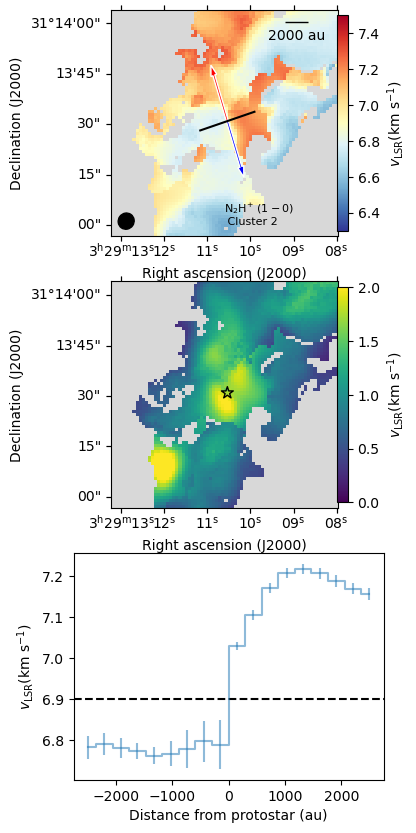

In [95]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(311, projection=WCS(iras4a_n2hphead).celestial)
map = iras4a_n2hpcluster[1]
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')
vmin = iras4a_vlsr-0.6
vmax = iras4a_vlsr+0.6

label = r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
#ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('N$_2$H$^{+}$ ($1-0$)\n Cluster 2', (0.5, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'],  0.004*np.sin((19*u.deg).to(u.rad).value), 0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'],  -0.004*np.sin((19*u.deg).to(u.rad).value), -0.004*np.cos((19*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

ax2 = fig.add_subplot(312, projection=WCS(iras4a_n2hphead).celestial)
map = iras4a_n2hpcluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
sc2 = ax2.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc2, ax=ax2, label=label, pad=-0.002, shrink=0.95)
ax2.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax2.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')


pa_angle = (19+90)*u.deg #degrees from north
mom1image = iras4a_n2hpcluster[1]
mom1unc = iras4a_n2hpcluster[4]
wcssky_n2hp = WCS(iras4a_n2hphead).celestial
centerxdeg, centerydeg = catalog_protostars.loc[1, 'RAJ2000']*u.deg, catalog_protostars.loc[1, 'DEJ2000']*u.deg
length = (5000 / 293 *u.arcsec).to(u.deg)
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length, angle=pa_angle)
pathcoords = pathcenter._coords
(xend, xstart), (yend, ystart) = wcssky_n2hp.wcs_world2pix(pathcoords.ra, pathcoords.dec,0)
centerxpix, centerypix = wcssky_n2hp.all_world2pix(centerxdeg, centerydeg, 0)
samplenum = np.amax([int(np.abs(xstart-xend)+1), int(np.abs(ystart-yend)+1)])
xlist, ylist = np.linspace(xend,xstart, samplenum), np.linspace(yend, ystart, samplenum)
distancepix = np.sqrt((xlist-centerxpix)**2+(ylist-centerypix)**2) * np.sign(xlist-centerxpix)
distanceau = distancepix * iras4a_n2hphead['CDELT2'] * 3600 * 293 # au
mom1eval = mom1image.copy()
mom1unceval = mom1unc.copy()
mom1eval[np.where(np.isnan(mom1image))] = 0
mom1unceval[np.where(np.isnan(mom1image))] = 0
zi = ndimage.map_coordinates(np.transpose(mom1eval), np.vstack((xlist, ylist)))
ziunc = ndimage.map_coordinates(np.transpose(mom1unceval), np.vstack((xlist, ylist)))

ax.plot(pathcoords.ra.value, pathcoords.dec.value,transform=ax.get_transform('world'), color='k')
ax3 = fig.add_subplot(313)
ax3.errorbar(distanceau, zi, yerr=ziunc, drawstyle='steps-mid', alpha=0.5)
ax3.axhline(iras4a_vlsr, color='k', linestyle='dashed')
ax3.set_xlabel('Distance from protostar (au)')
ax3.set_ylabel(r'$v_{\mathrm{LSR}}$(km s$^{-1}$)')
fig.savefig('figures/zoom_iras4a_n2hp_tmb_vlsr_cut.pdf', bbox_inches='tight', dpi=300)

In [48]:
# IRAS 2B

iras2b_hc3nclusterfile = 'analysis/protostar_cutouts/IRAS2B_HC3N_mlex1.fits'
iras2b_regionfile = 'analysis/protostar_cutouts/candidate_region_IRAS2B.reg'

iras2b_hc3ncluster, iras2b_hc3nhead = fits.getdata(iras2b_hc3nclusterfile, header=True)
iras2b_wcsskyhc3n = WCS(iras2b_hc3nhead).celestial
iras2b_region = Regions.read(iras2b_regionfile)[0]
iras2b_vlsr = catalog_protostars.loc[6, 'vlsr']

/tmp/ipykernel_27592/1783030795.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_27592/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


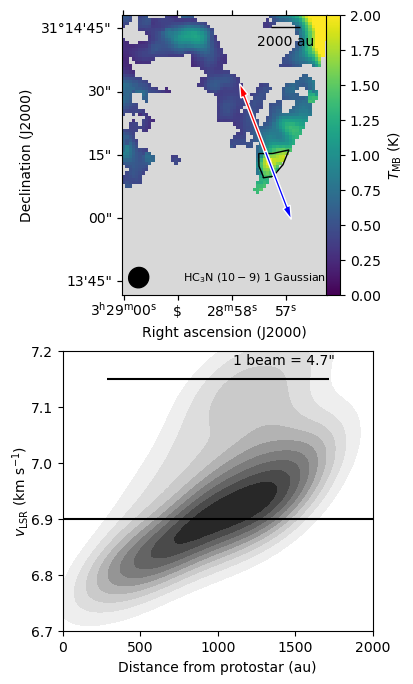

In [56]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=iras2b_wcsskyhc3n)
map = iras2b_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2

vmin = iras2b_vlsr-0.5
vmax = iras2b_vlsr+0.5
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
reg_load_pix = iras2b_region.to_pixel(iras2b_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax)
# ax.scatter(catalog_protostars.loc[1, 'RAJ2000'], catalog_protostars.loc[1, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate(r'HC$_3$N ($10-9$) 1 Gaussian', (0.3, 0.05), xycoords='axes fraction', fontsize=8)
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
# outflow
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  0.004*np.sin((24*u.deg).to(u.rad).value), 0.004*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'],  -0.004*np.sin((24*u.deg).to(u.rad).value), -0.004*np.cos((24*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(iras2b_hc3ncluster[1], iras2b_hc3nhead, catalog_protostars.loc[6, 'RAJ2000'], catalog_protostars.loc[6, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 2000, vmin, vmax)

ax2 = fig.add_subplot(212)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(iras2b_vlsr, color='k')
ax2.set_ylim([6.7, 7.2])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.55, 0.95), xycoords='axes fraction')

fig.savefig('figures/zoom_iras2b_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)


In [97]:
# SK 15

sk15_hc3nclusterfile = 'analysis/protostar_cutouts/SK15_HC3N_mlex2.fits'
sk15_n2hpclusterfile = 'analysis/protostar_cutouts/SK15_N2Hp_cluster0.fits'
sk15_regionfile = 'analysis/protostar_cutouts/candidate_region_SK15.reg'

sk15_hc3ncluster, sk15_hc3nhead = fits.getdata(sk15_hc3nclusterfile, header=True)
sk15_n2hpcluster, sk15_n2hphead = fits.getdata(sk15_n2hpclusterfile, header=True)
sk15_wcsskyhc3n = WCS(sk15_hc3nhead).celestial
sk15_region = Regions.read(sk15_regionfile)[0]
sk15_vlsr = catalog_protostars.loc[15, 'vlsr']

/tmp/ipykernel_27592/568143686.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_27592/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


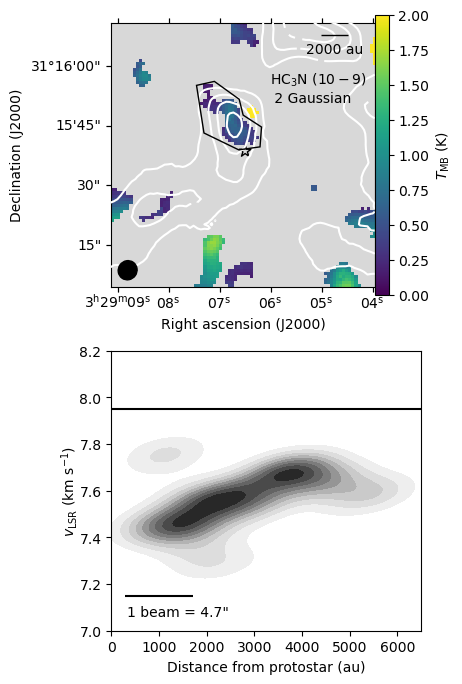

In [130]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=sk15_wcsskyhc3n)
map = sk15_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
vmin = 7
vmax = 8.2
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002)
reg_load_pix = sk15_region.to_pixel(sk15_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
ax.scatter(catalog_protostars.loc[15, 'RAJ2000'], catalog_protostars.loc[15, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 2 Gaussian', (0.6, 0.7), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')

add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
ax.contour(sk15_n2hpcluster[0], transform=ax.get_transform(WCS(sk15_n2hphead).celestial), levels=[2,3,4,5], colors='w')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

xx, yy, zz = do_kde(sk15_hc3ncluster[1], sk15_hc3nhead, catalog_protostars.loc[15, 'RAJ2000'], catalog_protostars.loc[15, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 6500, vmin, vmax)

ax2 = fig.add_subplot(212)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(sk15_vlsr, color='k')
ax2.set_ylim([vmin, vmax])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=7.15, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.05, 0.05), xycoords='axes fraction')

fig.savefig('figures/zoom_sk15_hc3n_tmb_wn2hp.pdf', bbox_inches='tight', dpi=300)


In [138]:
# SK 14 -Per-emb-15

per15_hc3nclusterfile = 'analysis/protostar_cutouts/Per-emb-15_HC3N_mlex1.fits'
per15_n2hpclusterfile = 'analysis/protostar_cutouts/Per-emb-15_N2Hp_cluster2.fits'
per15_regionfile = 'analysis/protostar_cutouts/candidate_region_Per-emb-15.reg'

per15_hc3ncluster, per15_hc3nhead = fits.getdata(per15_hc3nclusterfile, header=True)
per15_wcsskyhc3n = WCS(per15_hc3nhead).celestial
per15_region = Regions.read(per15_regionfile)[0]
per15_vlsr = catalog_protostars.loc[4, 'vlsr']

/tmp/ipykernel_27592/600657320.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis').copy()
/tmp/ipykernel_27592/2412344006.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  centerxsmall, centerysmall = int(centerxsmall), int(centerysmall)


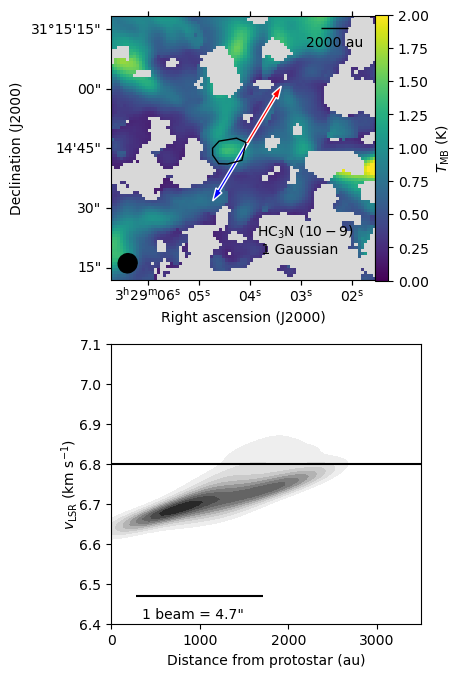

In [139]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(211, projection=per15_wcsskyhc3n)
map = per15_hc3ncluster[0]
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad('0.85')
tmin=0
tmax=2
vmin = 6.4
vmax = 7.1
label = r'$T_{\mathrm{MB}}$ (K)'#r'$v_{\mathrm{LSR}}$(km s$^{-1}$)'

sc1 = ax.imshow(map, cmap=cmap, vmin=tmin, vmax=tmax)
fig.colorbar(sc1, ax=ax, label=label, pad=-0.002, shrink=0.95)
reg_load_pix = per15_region.to_pixel(per15_wcsskyhc3n)
reg_load_pix.visual['edgecolor'] = 'black'
reg_load_pix.plot(ax=ax, zorder=100)
# ax.scatter(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'], transform=ax.get_transform('world'), marker='*', s=80, ec ='k', fc='None')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='k', pad=0.1)
ax.annotate('HC$_3$N ($10-9$)\n 1 Gaussian', (0.55, 0.1), xycoords='axes fraction', fontsize=10, color='k')
# ax.annotate('N$_2$H$^+$ ($1-0$)\n Cluster 0', (0.6, 0.55), xycoords='axes fraction', fontsize=10, color='w')
add_scalebar(ax, 2000/293*u.arcsec, corner='top right', label='2000 au')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
# outflow
ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  0.004*np.sin((145*u.deg).to(u.rad).value), 0.004*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='b', ec='w', width=0.0002)
ax.arrow(catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'],  -0.004*np.sin((145*u.deg).to(u.rad).value), -0.004*np.cos((145*u.deg).to(u.rad).value), transform=ax.get_transform('world'), fc='r', ec='w', width=0.0002)



xx, yy, zz = do_kde(per15_hc3ncluster[1], per15_hc3nhead, catalog_protostars.loc[4, 'RAJ2000'], catalog_protostars.loc[4, 'DEJ2000'], 
                    reg_load_pix, 293, 0, 3500, vmin, vmax)
ax2 = fig.add_subplot(212)
ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(per15_vlsr, color='k')
ax2.set_ylim([vmin, vmax])
ax2.set_xlabel('Distance from protostar (au)')
ax2.set_ylabel(r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)',labelpad=-0.1)
ax2.hlines(y=6.47, xmin=1000-(bmaj.to(u.arcsec).value/2*293), xmax=1000+(bmaj.to(u.arcsec).value/2*293), color='k')
ax2.annotate('1 beam = 4.7"', (0.1, 0.02), xycoords='axes fraction')

fig.savefig('figures/zoom_per15_hc3n_tmb.pdf', bbox_inches='tight', dpi=300)
